In [1]:
import torch
import warnings
warnings.filterwarnings("ignore")
torch.cuda.is_available()

True

In [2]:
import pandas as pd

df = pd.read_csv('..\\datasets\\bbc-cleaned.csv')
df

,category,text
0,business,ad sale boost time warner profit quarter profi...
1,business,dollar gain greenspan speech dollar hit highes...
2,business,yuko unit buyer face loan claim owner embattl ...
3,business,high fuel price hit ba profit british airway b...
4,business,pernod takeov talk lift domecq share uk drink ...
...,...,...
2220,tech,bt program beat dialler scam bt introduc two i...
2221,tech,spam e mail tempt net shopper comput user acro...
2222,tech,care code new european direct could put softwa...
2223,tech,us cyber secur chief resign man make sure us c...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [4]:
df['category'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [5]:
df.loc[0]['text']

'ad sale boost time warner profit quarter profit us media giant timewarn jump bn three month decemb year earlier firm one biggest investor googl benefit sale high speed internet connect higher advert sale timewarn said fourth quarter sale rose bn bn profit buoy one gain offset profit dip warner bros less user aol time warner said friday own search engin googl internet busi aol mix fortun lost subscrib fourth quarter profit lower preced three quarter howev compani said aol under profit except item rose back stronger internet advertis revenu hope increas subscrib offer onlin servic free timewarn internet custom tri sign aol exist custom high speed broadband timewarn also restat result follow probe us secur exchang commiss sec close conclud time warner fourth quarter profit slight better analyst expect film divis saw profit slump help box offic flop alexand catwoman sharp contrast year earlier third final film lord ring trilog boost result full year timewarn post profit bn perform revenu 

In [46]:
df['length'] = df['text'].apply(lambda x: len(x.split()))
df['length']

0        247
1        229
2        159
3        245
4        166
        ... 
2220     244
2221     216
2222     543
2223     221
2224    1466
Name: length, Length: 2225, dtype: int64

                mean: 219
       harmonic mean: 177


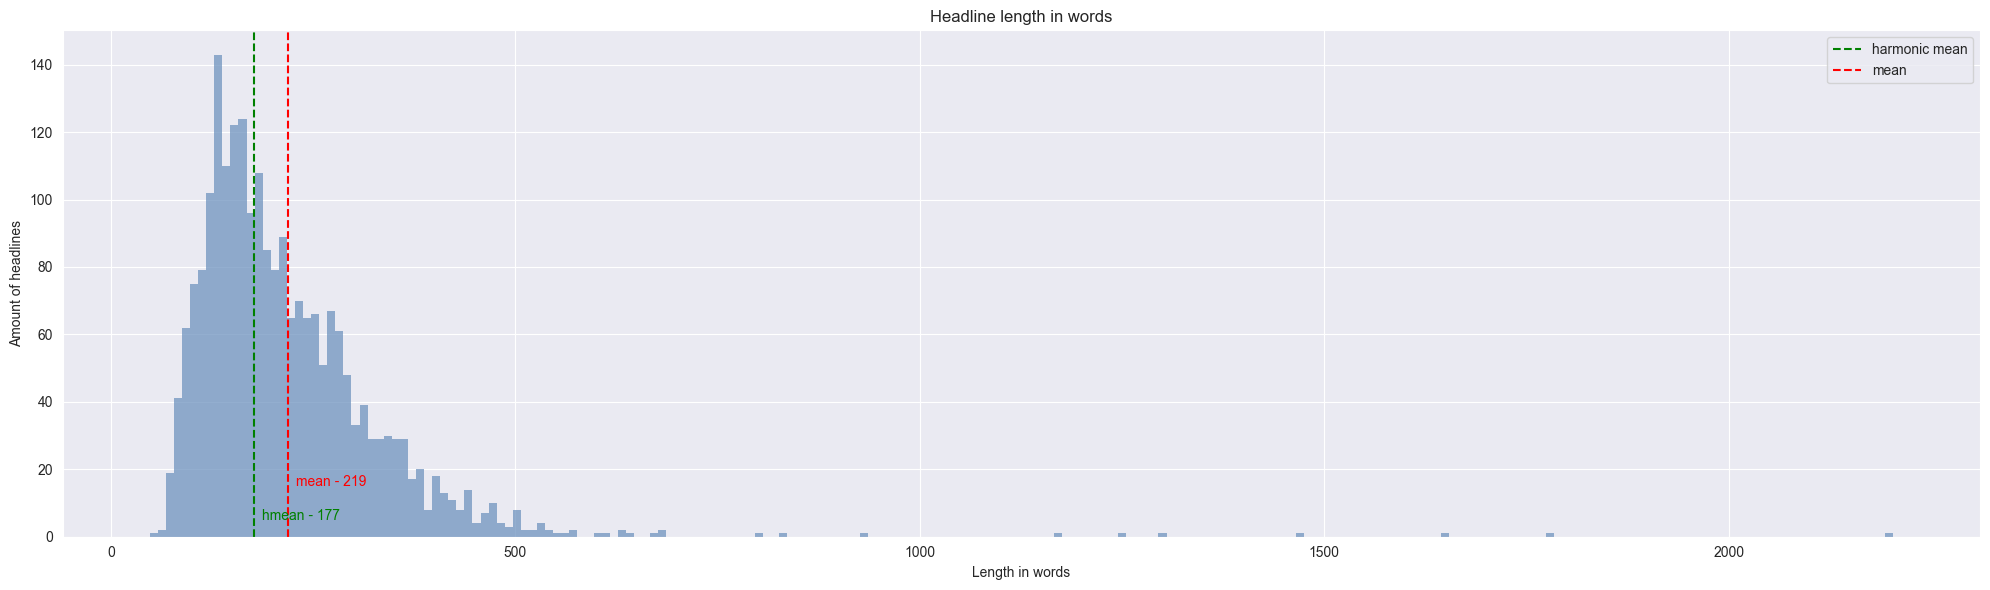

In [47]:
from matplotlib import pyplot as plt
from scipy.stats import hmean
import seaborn as sb

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

min_headline_len = df['length'].min()
max_headline_len = df['length'].max()

headline_mean = round(df['length'].mean())
headline_hmean = round(hmean(df['length']))

print(
    f"{"mean":>20}: {headline_mean}",
    f"{"harmonic mean":>20}: {headline_hmean}", sep='\n'
)

fig, axes = plt.subplots(figsize=(20, 6))

sb.histplot(df['length'], ax=axes, binwidth=10, linewidth=0, color=mid_blue)
axes.axvline(headline_hmean, color='g', linestyle='--', label='harmonic mean')
axes.annotate(text=f"hmean - {headline_hmean}", xy=(headline_hmean+10, 5), color='g')
axes.axvline(headline_mean, color='r', linestyle='--', label='mean')
axes.annotate(text=f"mean - {headline_mean}", xy=(headline_mean+10, 15), color='r')

axes.set_title('Headline length in words')
axes.set_xlabel('Length in words')
axes.set_ylabel('Amount of headlines')
axes.legend()

plt.tight_layout()

In [ ]:
headline_cut_to = lambda min, max: (df['headline_len'] > min) & (df['headline_len'] <= max)

shorter_than_100 = len(df[headline_cut_to(0, 100)])
longer_than_100 = len(df) - len(df[headline_cut_to(0, 100)])

print(
    "Amount of headlines",
    f"  shorter/equal to 100: {shorter_than_100:_}",
    f"       longer than 100: {longer_than_100:_}", sep='\n'
)

Since we're going to train our model on most average headline length. <br>
I don't see any point to use such small fraction of data. <br>
It can be very problematic for training our model. So we can safely remove it.

In [ ]:
sorted_categories = df['category'].value_counts().index

fig, axes = plt.subplots(figsize=(10, 10))

min_label = df['category'].value_counts().min()
max_label = df['category'].value_counts().max()

print(
    f"min: {min_label}",
    f"max: {max_label}", sep='\n'
)

sb.countplot(df['category'], order=sorted_categories, color=mid_blue)
axes.axvline(x=5_000, color='red', linestyle='--')
plt.tight_layout()

#### Downsampling

In [ ]:
from sklearn.utils import resample

target = 5_000

all_groups = []

for label, group in df.groupby('category'):
    if len(group) >= target:
        resampled_group = group.sample(n=target, random_state=42, replace=False)
        all_groups.append(resampled_group)
    else:
        all_groups.append(group)

df = pd.concat(all_groups)

In [ ]:
df['category'].value_counts()

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

#### Tokenizing headlines
1) shuffle dataset so train and test contain exact amount of each category
2) apply tokenizing function

In [ ]:
import re

def text_clean(text):
    result = text.lower()
    result = re.sub(r'[^a-zA-Z\s]', '', result)
    result = re.sub(r' +', ' ', result)
    return result

In [ ]:
sample = '!@#this is "a   "sample! (T*eXt)...'
print(
    f"Before: {sample}",
    f"After: {text_clean(sample)}", sep='\n'
)

In [ ]:
df['headline'] = df['headline'].apply(lambda x: text_clean(str(x)))
df

In [ ]:
df['headline_len'] = df['headline'].apply(lambda x: len(str(x).split()))
df['headline_len']

In [ ]:
df = df[headline_cut_to(3, 150)]

In [ ]:
from collections import Counter

tokenized_texts = [text.split() for text in df['headline']]
word_counts = Counter([word for text in tokenized_texts
                            for word in text])
word_counts.most_common(10)

In [ ]:
word_to_idx = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common())}
word_to_idx['<PAD>'] = 0
idx_to_word = {i: word for word, i in word_to_idx.items()}

for i in range(10):
    print(idx_to_word[i])

In [ ]:
import numpy as np

def vectorize_headline(headline):
    result = [word_to_idx[w] for w in headline.split()[:100]]
    result = np.pad(result, (0, 100 - len(result)))
    return result

In [ ]:
vectorize_headline(df['headline'][0])

In [ ]:
df['headline'] = df['headline'].apply(vectorize_headline)
df.head()

#### Labeling categories

In [ ]:
category_to_label = {
    cat: i for i, cat in enumerate(sorted_categories)
}

category_to_label

In [ ]:
df['category'] = df['category'].apply(lambda cat: category_to_label[cat])
df.head()

#### Data Loaders

In [ ]:
sequences = df['headline'].to_numpy()
labels = df['category'].to_numpy()

Checking if sequence is paired with label correctly

In [ ]:
mismatches = df[df['headline'] != sequences]
if not mismatches.empty:
    print(mismatches.iloc[0], sequences[mismatches.index[0]])
    
mismatches = df[df['category'] != labels]
if not mismatches.empty:
    print(mismatches.iloc[0], sequences[mismatches.index[0]])

In [ ]:
train_size = int(len(df) * 0.7)

train_split = sequences[:train_size], labels[:train_size]
test_split = sequences[train_size:], labels[train_size:]

In [ ]:
len(test_split[0]) + len(train_split[0]) == len(df)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def return_loader(dataset, batch_size=8):

    sequences, labels = dataset
        
    x, y, z = [], [], []
    
    for sequence, label in zip(sequences, labels):
        x.append(sequence)
        y.append(label)
        z.append(np.count_nonzero(sequence))
        
    tensor_dataset = TensorDataset(torch.tensor(x).long(),
                                   torch.tensor(z).long(),
                                   torch.tensor(y).long())
    
    return DataLoader(tensor_dataset, batch_size=batch_size, drop_last=True)

In [ ]:
train_loader  = return_loader(dataset=train_split, batch_size=256)
test_loader = return_loader(dataset=test_split, batch_size=256)

In [ ]:
i = -1

for batch in train_loader:
    inputs, lengths, targets = batch
    
    # print(len(lengths))
    for i in range(256):
        if 0 in lengths[i]:
            print(inputs[i], targets[i], lengths[i])

In [ ]:
from torch import nn
import torch.nn.utils.rnn as rnn_utils

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, n_layers=1, dropout_rate=0):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, dropout=dropout_rate, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, lengths):
        x = self.embedding(x)

        x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
    
        rnn_out, (hidden, cell) = self.rnn(x)    
    
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        
        return output

In [ ]:
from torch import optim

def train_model(model, data_loader, n_epochs=1, learning_rate=0.001):
    
    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epochs):
        
        model.train()
        total_loss = 0
        
        for i, batch in enumerate(data_loader):
            inputs, lengths, targets = batch
            inputs, targets = (inputs.to(device).long(), targets.to(device).long())
            lengths = lengths.cpu()
            
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            
            loss = criterion(outputs, targets)
            loss.backward()
            
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(data_loader)
        
        print(
            f"Epoch: {epoch+1} / {n_epochs}  |  loss: {avg_loss:.4f}"
        )

In [ ]:
def test_model(model, data_loader):

    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()

    y_true = []
    y_pred = []

    with (torch.no_grad()):
        for inputs, lengths, targets in data_loader:
            inputs, targets = inputs.to(device).long(), targets.to(device).long()
            lengths = lengths.cpu()
            if 0 in lengths:
                print(lengths)
            
            
            outputs = model(inputs, lengths)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# tRAINING

In [ ]:
rnn_model = RNN(vocab_size=len(word_to_idx),
                embed_size=256,
                hidden_size=256,
                dropout_rate=0,
                n_layers=1,
                output_size=42)

In [ ]:
train_model(
    model=rnn_model,
    data_loader=train_loader,
    n_epochs=10,
    learning_rate=0.001)

In [ ]:
y_true, y_pred = test_model(model=rnn_model, data_loader=test_loader)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=category_to_label))

In [ ]:
fig = plt.figure(figsize=(20, 20))
sb.heatmap(cm, cbar=False, cmap='Greys', annot=False, fmt='d')